## Airbnb Destination Prediction

Kaggle's Airbnb new user bookings data. Aim is to predict destination. More info <a href="https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview">here.</a>

### Table of Contents

1. [Imports](#Imports)    
2. [Data](#Data)  
3. [EDA](#EDA)  
4. [Preprocess](#Preprocess)
5. [Models](#Models)  
  5.1 [Decision Tree](#Decision_Tree)  
  5.2 [Extra Tree](#Extra_Tree)  
  5.3 [Random Forest](#Random_Forest)  
  5.4 [Bagging](#Bagging)  
  5.5 [XGBoost](#XGBoost)  
  5.6 [LightGBM](#LightGBM)  
  5.7 [KNN](#KNN) 

### Imports

In [1]:
# main
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle

# datetimes
import datetime as dt
from datetime import datetime
import time

# dataviz
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# plot style
%config InteractiveShellApp.pylab_import_all = False
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7)

plt.style.use('seaborn-colorblind')

# outline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%precision %.3f

# pandas display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Data

In [2]:
df_train = pd.read_csv('../data/airbnb-bookings/train_users.csv')
df_test = pd.read_csv('../data/airbnb-bookings/test_users.csv')
dfs = [df_train, df_test]

In [3]:
df_all = pd.concat((df_train.drop(['country_destination'], axis = 1), df_test), axis = 0, ignore_index= True)
df_all.head()
len(df_all)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


275547

In [4]:
# missing values as perc
df_all.isna().mean()

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.677340
gender                     0.000000
age                        0.424124
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.022083
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
dtype: float64

### EDA

In [5]:
df_all.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,gxn3p5htnn,820tgsjxq7,4ft3gnwmtx,bjjt8pjhuk,87mebub9p4,osr2jwljor,lsw9q7uk0j,0d01nltbrs,a1vcnhxeij,6uh8zyj2gn
date_account_created,2010-06-28,2011-05-25,2010-09-28,2011-12-05,2010-09-14,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-04
timestamp_first_active,20090319043255,20090523174809,20090609231247,20091031060129,20091208061105,20100101215619,20100102012558,20100103191905,20100104004211,20100104023758
date_first_booking,NaN,NaN,2010-08-02,2012-09-08,2010-02-18,2010-01-02,2010-01-05,2010-01-13,2010-07-29,2010-01-04
gender,-unknown-,MALE,FEMALE,FEMALE,-unknown-,-unknown-,FEMALE,FEMALE,FEMALE,-unknown-
age,NaN,38,56,42,41,NaN,46,47,50,46
signup_method,facebook,facebook,basic,facebook,basic,basic,basic,basic,basic,basic
signup_flow,0,0,3,0,0,0,0,0,0,0
language,en,en,en,en,en,en,en,en,en,en
affiliate_channel,direct,seo,direct,direct,direct,other,other,direct,other,other


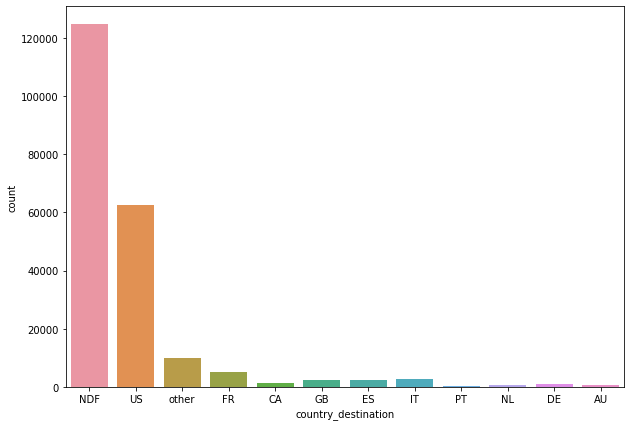

In [6]:
# Target = Country Destination
sns.countplot(x='country_destination',data=df_train)

In [7]:
# Gender
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

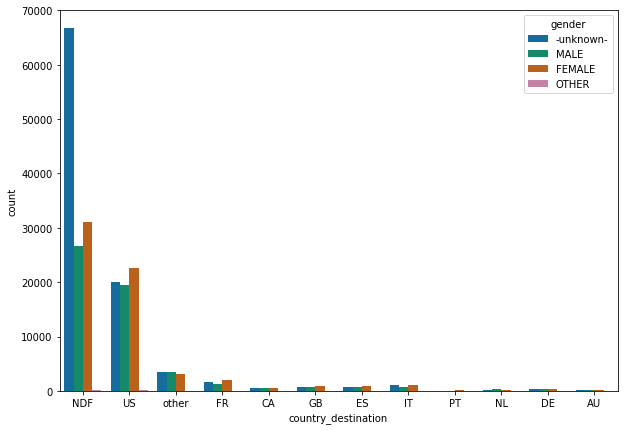

In [8]:
sns.countplot(x='country_destination', data=df_train,hue='gender')

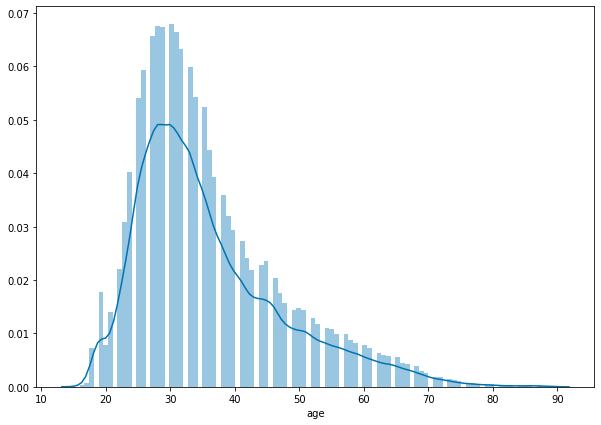

In [9]:
# Age

# has nulls and unrealistic values
df_all.loc[(df_all.age>=90)|(df_all.age<16),'age'] = np.nan
sns.distplot(df_all.age, bins=100)

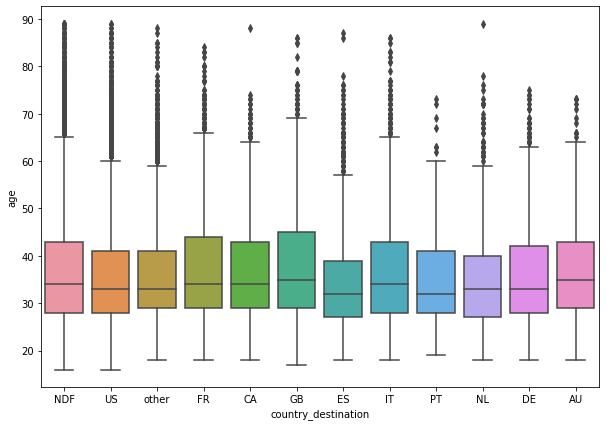

In [10]:
for df in dfs:
    df.loc[(df.age>=90)|(df.age<16),'age'] = np.nan
    
sns.boxplot(x='country_destination',y='age',data=df_train)

In [11]:
# Signup Method
df_all.signup_method.value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

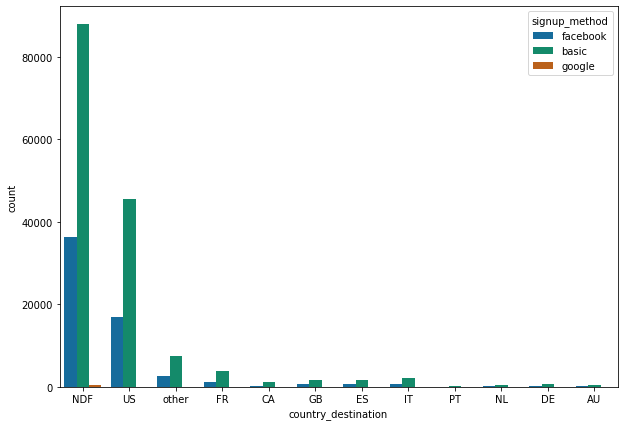

In [12]:
sns.countplot(x='country_destination', data=df_train,hue='signup_method')

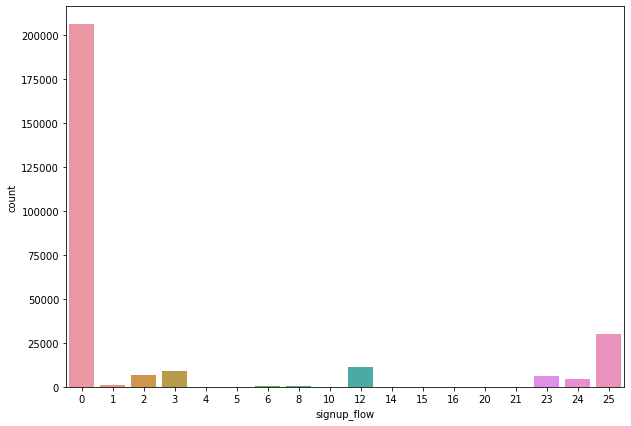

In [13]:
# Signup Flow
sns.countplot(x='signup_flow',data=df_all)

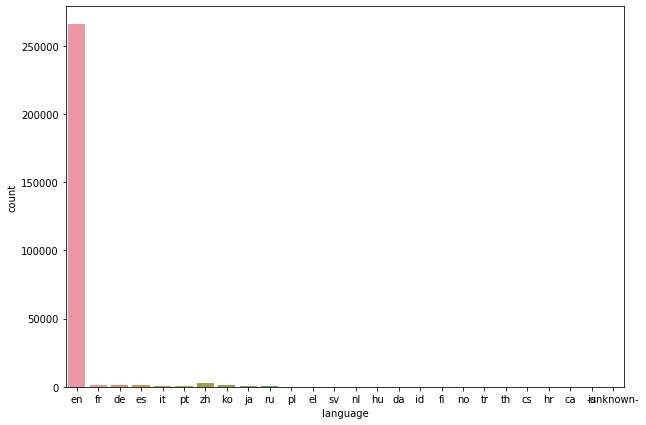

In [14]:
# Language
sns.countplot(x='language',data=df_all)

In [15]:
# Affiliate Channel
df_all.affiliate_channel.value_counts()

direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64

In [16]:
# Affiliate Provider
df_all.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64

In [17]:
# First Affiliate Tracked

# has nulls
df_all.first_affiliate_tracked.value_counts()

untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64

In [18]:
# Signup App
df_all.signup_app.value_counts()

Web        219918
iOS         34593
Android     10519
Moweb       10517
Name: signup_app, dtype: int64

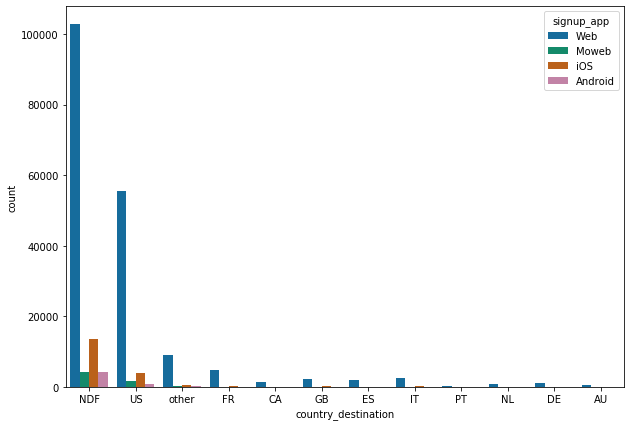

In [19]:
sns.countplot(x='country_destination', data=df_train,hue='signup_app')

In [20]:
# First Device Type
df_all.first_device_type.value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

In [21]:
# First Browser
df_all.first_browser.value_counts().head(15)

Chrome                78671
Safari                53302
-unknown-             44394
Firefox               38665
Mobile Safari         29636
IE                    24744
Chrome Mobile          3186
Android Browser        1577
AOL Explorer            254
Opera                   228
Silk                    172
IE Mobile               118
BlackBerry Browser       89
Chromium                 83
Mobile Firefox           64
Name: first_browser, dtype: int64

In [22]:
# Date Account Created
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'], format='%Y-%m-%d')
df_all['year_account_created'] = df_all['date_account_created'].dt.year
df_all['month_account_created'] = df_all['date_account_created'].dt.month

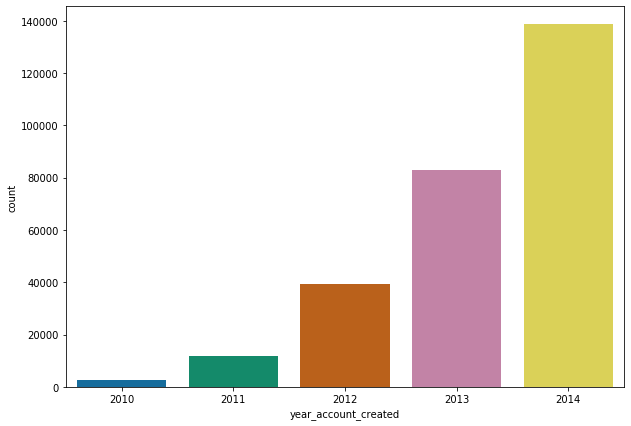

In [23]:
# Year Account Created
sns.countplot(x='year_account_created',data=df_all)

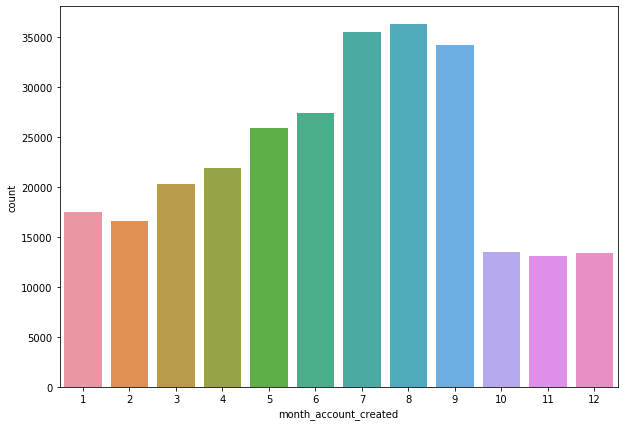

In [24]:
# Month Account Created
sns.countplot(x='month_account_created',data=df_all)

In [25]:
for df in dfs:
    df['date_account_created'] = pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')
    df['year_account_created'] = df['date_account_created'].dt.year
    df['month_account_created'] = df['date_account_created'].dt.month

<Figure size 1440x504 with 0 Axes>

Text(0, 0.5, 'num_bookings')

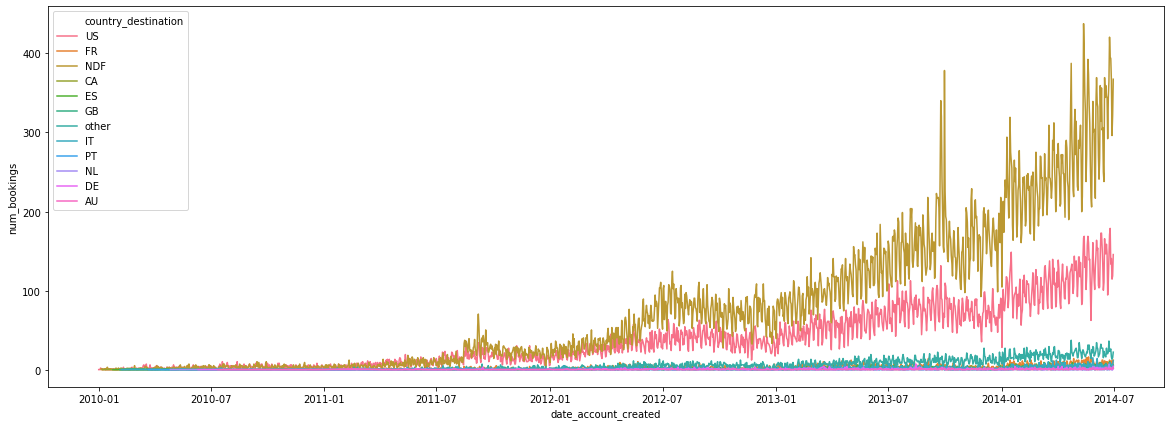

In [26]:
plt.figure(figsize=(20,7))
sns.lineplot(x='date_account_created',y='id',hue='country_destination',
             data=df_train.groupby(['date_account_created','country_destination'])['id'].count().reset_index())
plt.ylabel('num_bookings')

In [27]:
# Timestamp First Active
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')
df_all['date_first_active'] = df_all['timestamp_first_active'].dt.date
df_all['year_first_active'] = df_all['timestamp_first_active'].dt.year
df_all['month_first_active'] = df_all['timestamp_first_active'].dt.month

<Figure size 1440x504 with 0 Axes>

Text(0, 0.5, 'num_bookings')

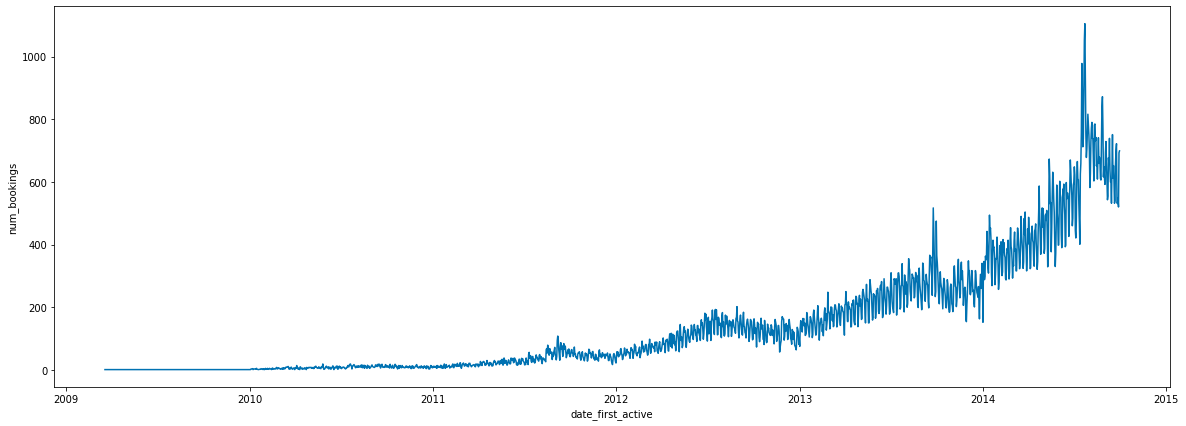

In [28]:
plt.figure(figsize=(20,7))
sns.lineplot(x='date_first_active',y='id',
             data=df_all.groupby('date_first_active')['id'].count().reset_index())
plt.ylabel('num_bookings')

Text(0, 0.5, 'num_bookings')

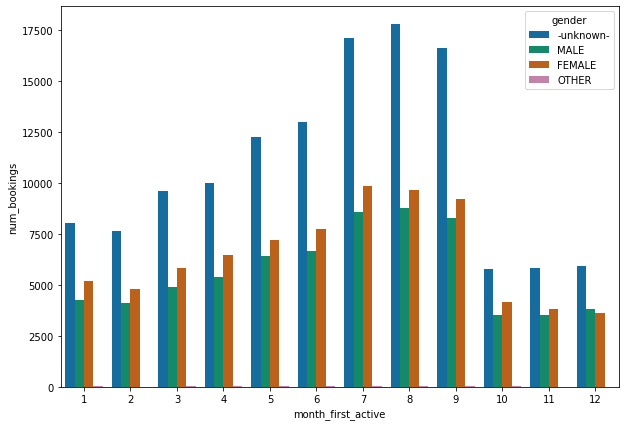

In [29]:
sns.countplot(x='month_first_active',hue='gender',data=df_all)
plt.ylabel('num_bookings')

In [30]:
for df in dfs:
    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
    df['date_first_active'] = df['timestamp_first_active'].dt.date
    df['year_first_active'] = df['timestamp_first_active'].dt.year
    df['month_first_active'] = df['timestamp_first_active'].dt.month

<Figure size 1440x504 with 0 Axes>

Text(0, 0.5, 'num_bookings')

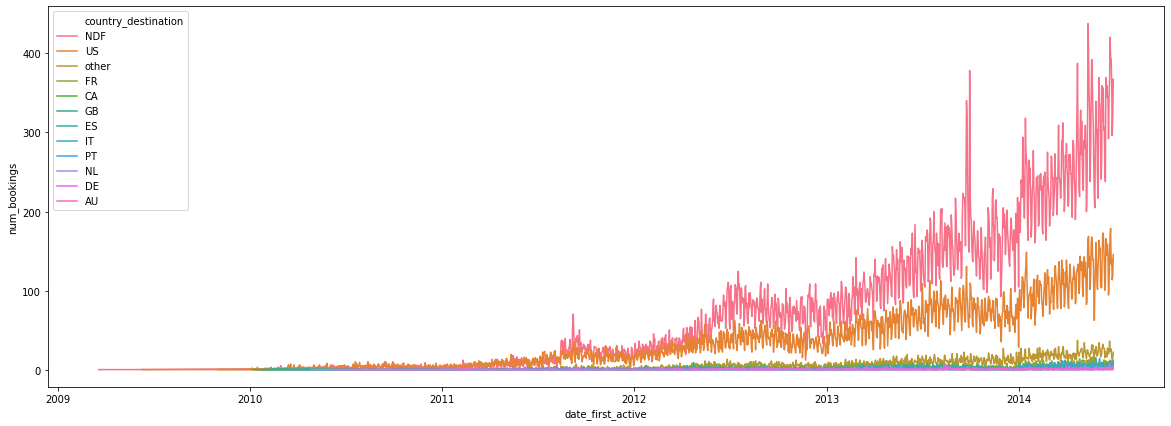

In [31]:
plt.figure(figsize=(20,7))
sns.lineplot(x='date_first_active',y='id',hue='country_destination',
             data=df_train.groupby(['date_first_active','country_destination'])['id'].count().reset_index())
plt.ylabel('num_bookings')

### Preprocess

In [32]:
drop_list = ['id','date_account_created','timestamp_first_active','date_first_booking','date_first_active']
cat_features = ['gender','signup_method','language','affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app',
               'first_device_type','first_browser']

# use only train so that we can evaluate several models

# drop cols
df_train.drop(drop_list,axis=1,inplace=True)

# fill na
df_train.fillna(-1,inplace=True)

# one hot encode
df_train = pd.get_dummies(df_train,columns=cat_features,drop_first=True)

In [33]:
# label encode
from sklearn.preprocessing import LabelEncoder
labels = df_train.country_destination.values
X = df_train.drop('country_destination',axis=1)
y = LabelEncoder().fit_transform(labels) 

# train and test split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

### Models

In [34]:
from sklearn.metrics import accuracy_score,f1_score

#### Decision_Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier 

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train) 
preds = dt.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy =  0.6308490901935798
F1 =  0.5865028378541455


#### Extra_Tree

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

b = ExtraTreesClassifier(max_depth=3)
b.fit(X_train, y_train) 
preds = b.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=3, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Accuracy =  0.5863800760826791
F1 =  0.433492072688901


#### Random_Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train, y_train) 
preds = rf.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy =  0.5871109195509998
F1 =  0.4354935190555446


#### Bagging

In [38]:
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(max_samples=10)
bg.fit(X_train, y_train) 
preds = bg.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=10, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

Accuracy =  0.5725502689129172
F1 =  0.48533792644554


#### XGBoost

In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=5,learning_rate=0.3,n_estimators=25) 
xgb.fit(X_train, y_train) 
preds = xgb.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy =  0.6364522234507055
F1 =  0.5877722117562615


#### LightGBM

In [40]:
import lightgbm as lgb

lgb = lgb.LGBMClassifier(max_depth=5,learning_rate=0.3,n_estimators=25) 
lgb.fit(X_train, y_train) 
preds = lgb.predict(X_test)

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.3, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=25, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Accuracy =  0.6366583587879242
F1 =  0.5881864023326493


#### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7,leaf_size=10)
knn.fit(X_train, y_train)
preds = knn.predict(X_test) 

print('Accuracy = ',accuracy_score(y_test, preds))
print('F1 = ',f1_score(y_test, preds,average='weighted'))

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

Accuracy =  0.5938384273747728
F1 =  0.5440446793989138
